# Obtaining Data

In [5]:
#Importing libraries needed
import pandas as pd
import numpy as np


#For graphing 
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
import shap

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn import svm, datasets
from sklearn import metrics



# For demonstrative pruposes
from scipy.special import logit, expit

import warnings
warnings.filterwarnings('ignore')

In [6]:
bottom = pd.read_csv(r"C:\Users\salom\OneDrive\Área de Trabalho\Flatiron\Capstone Materials\Capstone\data")

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\salom\\OneDrive\\Área de Trabalho\\Flatiron\\Capstone Materials\\Capstone\\data'

In [3]:
#opening the datasets 
bottom =  pd.read_csv(r'data\bottom_hurricane.csv')
middle =  pd.read_csv(r'data\middle_hurricane.csv')
top =  pd.read_csv(r'data\top_hurricane.csv')
all_df = pd.read_csv(r'data\all_hurricane.csv')

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\salom\\OneDrive\\Área de Trabalho\\Flatiron\\Capstone Materials\\Capstone\\data'

# Data Processing

In [ ]:
#let's get rid of duplicate cities by only grabbing the cities with the max value for AWND
bottom = bottom.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
middle = middle.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
top = top.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
all_df = all_df.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City', 'DATE']).sort_index()

In [ ]:
#We want to use data from hurricane Ian to test our mode
#let's save a dataframe that has just Ian 
all_ian = all_df.loc[all_df['HurricaneName'] == 'ian']
all_ian.head()

In [ ]:
#removing ian from the other datasets
bottom = bottom.drop(bottom[bottom['HurricaneName'] == 'ian'].index)
middle = middle.drop(middle[middle['HurricaneName'] == 'ian'].index)
top = top.drop(top[top['HurricaneName'] == 'ian'].index)
all_df = all_df.drop(all_df[all_df['HurricaneName'] == 'ian'].index)

In [ ]:
#saving the all dataset for use in later analysis 
all_df.to_csv(r'data\wind_modeling.csv', index=False)

## Comparing Crosstabs by Target Variable

### Bottom Tier Home Values

In [ ]:
#check crosstabs 
bottom[bottom['increase'] == 0].describe()

In [ ]:
#check crosstabs 
bottom[bottom['increase'] == 1].describe()

### Middle Tier Home Values

In [ ]:
#check crosstabs 
middle[middle['increase'] == 0].describe()

In [ ]:
#check crosstabs 
middle[middle['increase'] == 1].describe()

### Top Tier Home Values

In [ ]:
#check crosstabs 
top[top['increase'] == 0].describe()

In [ ]:
#check crosstabs 
top[top['increase'] == 1].describe()

### All Home Values 

In [ ]:
#check crosstabs 
all_df[all_df['increase'] == 0].describe()

In [ ]:
#check crosstabs 
all_df[all_df['increase'] == 1].describe()

# Baseline Model

## Examining Class Imbalance

In order to know what a good accuracy is for our models, we must know what the majority class percent is. This will tell us if our model performs any better than just selecting the majority class each time. 

|Dataset | Increase | No Increase | No Increase as Percent |
|---|---|---|---|
|Bottom Tier| 45 | 96| 68% |
|Middle Tier| 33 | 106 | 76% |
|Top Tier| 28 | 114 | 80% |
|All| 89 | 255 | 74% |

#### Bottom Tier Class Imabalance

In [ ]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=bottom).set(title='Bottom Tier Home Class Imbalance')
print(bottom['increase'].value_counts())
#checking ratio to see what accuracy is like
percent_bottom = (len(bottom['increase']) - bottom['increase'].sum())/(len(bottom['increase']) - bottom['increase'].sum()+bottom['increase'].sum())*100
print("majority percent is {}".format(percent_bottom),"%")


#### Middle Tier Class Imbalance

In [ ]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=middle).set(title='Middle Tier Home Class Imbalance')
print(middle['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(middle['increase']) - middle['increase'].sum())/(len(middle['increase']) - middle['increase'].sum()+middle['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

#### Top Tier Class Imbalance

In [ ]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=top).set(title='Top Tier Home Class Imbalance')
print(top['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(top['increase']) - top['increase'].sum())/(len(top['increase']) - top['increase'].sum()+top['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### All Homes Class Imbalance

In [ ]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=all_df);
print(all_df['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_df['increase']) - all_df['increase'].sum())/(len(all_df['increase']) - all_df['increase'].sum()+all_df['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

# Modeling 

Of equal concern to the business problem was the model predicting False Negatives or False Positives. In this situation both are of equal importance to our real estate client. If the model predicts that the home value will not increase but it does (false negative) then our client could lose out on a possible higher return on a home. However, if the model predicts that the home value will increase but it does not (false positive) then our client may have invested money into a home that does not pay off. 

For the scope of this project we will be using accuracy and F1 score to assess our model performance. Since we had a class imbalance we could not solely rely on accuracy to communicate model performance. Since, precision and recall were of equal importance for our business problem F1 score was used to assess model performance. 

- **Model accuracy** is a machine learning classification model performance metric that takes the ratio of true positives and true negatives to all positives and negative results. It communicates how often our model will correctly predict an outcome out of the total number of predictions made. However, accuracy metrics are not always reliable for imbalance datasets. Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)  

- **Model F1 Score** is a model performance metric that gives equal weight to both the Precision and Recall for measuring performance. F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)    

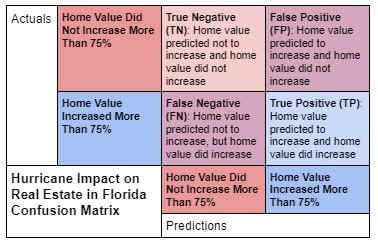

**Works Cited**   
Kumar A. Accuracy, Precision, Recall & F1-Score - Python Examples. Data Analytics. Published October 1, 2021. https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

### Logistic Regresion

A logistic regression model was iterated through with our scaled data. We removed collinear variables and used SMOTE to adjust for the class imbalance. The logistic regression model that performed the best was our SMOTE model with no colinear features and had an accuracy of 0.74 which was slightly better than our baseline accuracy of 0.68 and an F1 score of 0.68. 

In [ ]:
#establishing model 
logreg = LogisticRegression(random_state=56)

## Model 1: Bottom Tier Housing

We will use the bottom tier housing for modeling since it has the best class imbalance. 

### Selecting Our Target Variable and Features
Our targer variable is increase and for our first iteration of modeling we will use all the available features. 

In [ ]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split

In [ ]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [ ]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Training Data

In [ ]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [ ]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

### Testing Data

In [ ]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [ ]:
#Printing Accuracy
accuracy_1 = accuracy_score(y_test, y_pred_test)
print(accuracy_1)

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_1 = f1_score(y_test, y_pred_test)
print(F1_1)

In [ ]:
#initiating dictionary to keep model accuracy and F1 score
model_dict = {}
#recording baseline model accuracy
model_dict['Baseline Accuracy'] = percent_bottom
#recording model 1 values
model_dict['LGRModel1_Accuracy'] = accuracy_1
model_dict['LGRModel1_F1'] = F1_1
model_dict

In [ ]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
#https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 1', fontsize=18)
plt.show()

In [ ]:
#https://forecastegy.com/posts/feature-importance-in-logistic-regression/#feature-importance-in-binary-logistic-regression
#checking out feature importance

model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', title='Feature Importance for Log. Reg. Model 1', kind='barh', figsize=(10, 6));

## Model 2: Bottom Tier Housing Without Colinear Variables 

We will use the bottom tier housing for modeling since it has the best class imbalance. 

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [ ]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [ ]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [ ]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Training Data

In [ ]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [ ]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

### Testing Data

In [ ]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [ ]:
#Printing Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_test)
print(accuracy_2)

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_2 = f1_score(y_test, y_pred_test)
print(F1_2)

### Saving to Dictionary

In [ ]:
#adding to model dictionary
model_dict['LGRModel2_Accuracy'] = accuracy_2
model_dict['LGRModel2_F1'] = F1_2
model_dict

In [ ]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 2, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Confusion Matrix

In [ ]:
#plotting confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 2', fontsize=18)
plt.show()

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title= 'Feature Importance for Log. Reg. Model 2', figsize=(10, 6));

## Model 3: Bottom Tier Housing with Smote 

In [ ]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'WSF2'], axis=1)

### Train/Test Split

In [ ]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [ ]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### SMOTE

In [ ]:
# Create instance of smotec
from imblearn.over_sampling import SMOTE,SMOTENC
# set sampling_strategy to 0.8 to avoid oversampling
smote = SMOTE(sampling_strategy=0.8, random_state=56)

In [ ]:
# Create resampled version of the train dataset
SMOTE_X_train, SMOTE_y_train = smote.fit_resample(X_train, y_train)
# Create resampled version of the test dataset
SMOTE_X_test, SMOTE_y_test = smote.fit_resample(X_test, y_test)

In [ ]:
#before smote
print('Before Smote\n', y_train.value_counts())

#after smote
print('\nAfter Smote\n', SMOTE_y_train.value_counts())

### Training Data

In [ ]:
#fitting the model unto our training data
logreg.fit(SMOTE_X_train, SMOTE_y_train)
y_pred_train = logreg.predict(SMOTE_X_train)

#### Checking Metrics

In [ ]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(SMOTE_y_train, y_pred_train))

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(SMOTE_y_train, y_pred_train))

### Testing Data

In [ ]:
#fitting the model unto our test data
logreg.fit(SMOTE_X_test, SMOTE_y_test)
y_pred_test = logreg.predict(SMOTE_X_test)

#### Checking Metrics

In [ ]:
#Printing Accuracy
accuracy_3 = accuracy_score(SMOTE_y_test, y_pred_test)
print(accuracy_3)

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_3 = f1_score(SMOTE_y_test, y_pred_test)
print(F1_3)

In [ ]:
#adding metrics to dictionary
model_dict['LGRModel3_Accuracy'] = accuracy_3
model_dict['LGRModel3_F1'] = F1_3
model_dict

In [ ]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 3, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_true=SMOTE_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 3', fontsize=18)
plt.show()

### Feature Importance

In [ ]:
model = LogisticRegression()
model.fit(SMOTE_X_train, SMOTE_y_train)

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title= 'Feature Importance for Log. Reg. Model 3', figsize=(10, 6));

## XGBoost

In [ ]:
#initiating model
xgb = XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features

In [ ]:
#y is prediction variable 
#X is features 
y_boost = bottom['increase']
X_boost = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)


### Train/Test Split

In [ ]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

In [ ]:
xgb.fit(XG_X_train, XG_y_train);

In [ ]:
y_pred_train = xgb.predict(XG_X_train)

In [ ]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

### Testing Data

In [ ]:
xgb.fit(XG_X_test, XG_y_test);

In [ ]:
y_pred_test = xgb.predict(XG_X_test)

In [ ]:
#Printing Accuracy
accuracy_XG1 = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XG1)

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XG1 = f1_score(XG_y_test, y_pred_test)
print(F1_XG1)

In [ ]:
model_dict['XGBoost_Accuracy'] = accuracy_XG1
model_dict['XGBoost_F1'] = F1_XG1
model_dict

In [ ]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(XG_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(XG_y_test,  y_pred_prob)
auc = metrics.roc_auc_score(XG_y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="XG Boost, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Best Model on Test Set', fontsize=18)
plt.show()

## SHAP (SHapley Additive exPlanations) 

SHAP is a unified approach to explain the output of any machine learning model. Beeswarm plots are a more complex and information-rich display of SHAP values that reveal not just the relative importance of features, but their actual relationships with the predicted outcome. 

shap_values : the average contribution of each feature to each prediction for each sample based on all possible features. It is a (n,m) n — samples, m — features matrix that represents the contribution of each feature to each sample.

From the plot below we can interpret that larger SizeRank values have a higher impact on feature value. Smaller before values have a higher impact on feature value. Higher WSF2 and AWND values also have higher impact on feature value. 

Works Cited   
Classification Feature Selection : SHAP Tutorial. kaggle.com. Accessed July 6, 2023. https://www.kaggle.com/code/ritzig/classification-feature-selection-shap-tutorial#SHAP


In [ ]:
#Using SHAP to assess feature importance 
# creating an explainer for our model
explainer = shap.TreeExplainer(xgb)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(XG_X_test)

#creating a beeswarm plot 
shap.initjs()
plt.title("XGBoost Feature Importance", y=1)
shap.summary_plot(shap_values, XG_X_test)

# Best Model: XGBoost
We ran two types of models, logistic regression and XG Boost. The best logisitc regression model had an accuracy of 72% which is only slightly better than the majority percent of 68%. Our best model was XGBoost which had a perfect accuracy and F1 score with the included features:
- AWND
- WSF2
- SizeRank
- before 

In [ ]:
model_dict

# Model Validation 

## XGBoost on Hurricane Ian Data

In [ ]:
# Checking the balance of target variable 'increase'
#plotting 
sns.countplot(x='increase', data=all_ian).set(title='Hurricane Ian Class Imbalance')
#print value counts 
print(all_ian['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_ian['increase']) - all_ian['increase'].sum())/(len(all_ian['increase']) - all_ian['increase'].sum()+all_ian['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [ ]:
#y is prediction variable 
#X is features 
y_ian = all_ian['increase']
X_ian = all_ian.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

In [ ]:
y_pred = xgb.predict(X_ian)

In [ ]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_ian, y_pred))

In [ ]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_ian, y_pred))

In [ ]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(X_ian)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_ian,  y_pred_prob)
auc = metrics.roc_auc_score(y_ian, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="XG Boost for Hurricane Ian, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Confusion Matrix

As seen below 7 false negatives were predicted. Meaning home value was predicted not to increase, but it did. 

In [ ]:
conf_matrix = confusion_matrix(y_true=y_ian, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Hurricane Ian', fontsize=18)
plt.show()